<a href="https://colab.research.google.com/github/si-mong/AI_lab/blob/main/AI_week10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# License: BSD
# Author: Sasank Chilamkurthy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

In [ ]:
import shutil # Import shutil for directory removal
import glob # Import glob for finding files

cudnn.benchmark = True
plt.ion()   # interactive mode

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'sample_data/hymenoptera_data'
#data_dir = 'sample_data/sample_computer_vision'

# Remove .ipynb_checkpoints and .DS_Store files
for phase in ['train', 'val']:
    checkpoints_dir = os.path.join(data_dir, phase, '.ipynb_checkpoints')
    if os.path.exists(checkpoints_dir):
        print(f"Removing {checkpoints_dir}")
        shutil.rmtree(checkpoints_dir)
    # Find and remove .DS_Store files
    for ds_store_file in glob.glob(os.path.join(data_dir, phase, '**', '.DS_Store'), recursive=True):
        if os.path.exists(ds_store_file):
            print(f"Removing {ds_store_file}")
            os.remove(ds_store_file)


# Function to check if a file is valid (not in .ipynb_checkpoints and is a valid image file)
def is_valid_file(x):
    if '.ipynb_checkpoints' in x or x.endswith('.DS_Store'):
        return False
    try:
        Image.open(x).verify()  # Verify if it's a valid image file
        return True
    except Exception as e:
        print(f"Skipping file {x} due to error: {e}")
        return False


image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x],
                                          is_valid_file=is_valid_file) # Add is_valid_file argument
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# We want to be able to train our model on an `accelerator <https://pytorch.org/docs/stable/torch.html#accelerators>`__
# such as CUDA, MPS, MTIA, or XPU. If the current accelerator is available, we will use it. Otherwise, we use the CPU.

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Removing sample_data/hymenoptera_data/train/.ipynb_checkpoints
Removing sample_data/hymenoptera_data/val/.ipynb_checkpoints
Using cuda device


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


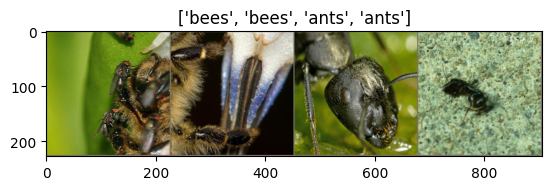

In [ ]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
# 사전학습된 모델 불러오기
model_ft = models.efficientnet_b3(weights='IMAGENET1K_V1')
#model_ft = models.resnet18(weights = 'IMAGENET1K_V1')

#마지막 레이어 입력 차원 가져오기
num_ftrs = model_ft.classifier[1].in_features
#num_ftrs = model_ft.fc.in_features

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth


100%|██████████| 47.2M/47.2M [00:00<00:00, 134MB/s]


In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 3.6784 Acc: 0.3959
val Loss: 6.3133 Acc: 0.5817

Epoch 1/24
----------
train Loss: 0.6109 Acc: 0.7388
val Loss: 1.5484 Acc: 0.7516

Epoch 2/24
----------
train Loss: 0.8058 Acc: 0.5714
val Loss: 45.9833 Acc: 0.5425

Epoch 3/24
----------
train Loss: 0.8060 Acc: 0.5714
val Loss: 6.7081 Acc: 0.5882

Epoch 4/24
----------
train Loss: 0.7735 Acc: 0.6000
val Loss: 1.2633 Acc: 0.5686

Epoch 5/24
----------
train Loss: 0.8037 Acc: 0.5633
val Loss: 0.7506 Acc: 0.6405

Epoch 6/24
----------
train Loss: 0.7366 Acc: 0.6204
val Loss: 8.7827 Acc: 0.6405

Epoch 7/24
----------
train Loss: 0.6748 Acc: 0.6531
val Loss: 1.1208 Acc: 0.6144

Epoch 8/24
----------
train Loss: 0.6915 Acc: 0.6490
val Loss: 1.9764 Acc: 0.6667

Epoch 9/24
----------
train Loss: 0.6574 Acc: 0.6898
val Loss: 0.6957 Acc: 0.6471

Epoch 10/24
----------
train Loss: 0.6818 Acc: 0.6082
val Loss: 2.8033 Acc: 0.6209

Epoch 11/24
----------
train Loss: 0.6470 Acc: 0.6408
val Loss: 4.3528 Acc: 0.6601

Epoch 12/24
----------


##ConvNet as fixed feature extractor

In [ ]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 161MB/s]


##Train and evaluate

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7934 Acc: 0.6286
val Loss: 0.4479 Acc: 0.8235

Epoch 1/24
----------
train Loss: 0.4514 Acc: 0.8041
val Loss: 0.2029 Acc: 0.9020

Epoch 2/24
----------
train Loss: 0.5537 Acc: 0.7184
val Loss: 0.3652 Acc: 0.8693

Epoch 3/24
----------
train Loss: 0.5193 Acc: 0.7592
val Loss: 0.2366 Acc: 0.9020

Epoch 4/24
----------
train Loss: 0.4268 Acc: 0.8204
val Loss: 0.3005 Acc: 0.8758

Epoch 5/24
----------
train Loss: 0.5616 Acc: 0.7510
val Loss: 0.2626 Acc: 0.9216

Epoch 6/24
----------
train Loss: 0.4184 Acc: 0.8286
val Loss: 0.1544 Acc: 0.9281

Epoch 7/24
----------
train Loss: 0.3954 Acc: 0.8163
val Loss: 0.1929 Acc: 0.9281

Epoch 8/24
----------
train Loss: 0.4120 Acc: 0.8163
val Loss: 0.2051 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.3568 Acc: 0.8612
val Loss: 0.1887 Acc: 0.9281

Epoch 10/24
----------
train Loss: 0.4747 Acc: 0.7755
val Loss: 0.1824 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.3229 Acc: 0.8490
val Loss: 0.1663 Acc: 0.9412

Ep

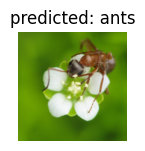

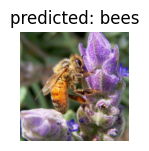

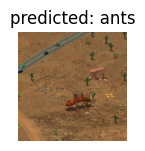

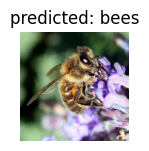

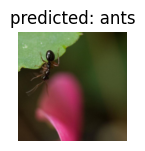

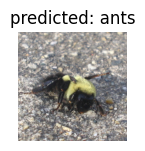

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()

##Inference on custom images

In [ ]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

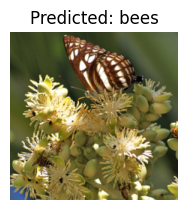

In [ ]:
visualize_model_predictions(
    model_conv,
    img_path='sample_data/hymenoptera_data/val/bees/72100438_73de9f17af.jpg'
)

plt.ioff()
plt.show()